### Importing Packages

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4
from netCDF4 import Dataset
import numpy  as np
import scipy
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator, StrMethodFormatter
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D

from gsw import p_from_z
from gsw import pot_rho_t_exact as prho

import seaborn as sns
# sns.reset_defaults()
sns.set_theme(style='darkgrid')
# sns.set_context('talk')

import datetime

from scipy import interpolate, ndimage
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import sys
import subprocess

from datetime import datetime, date

import glob
import os

import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath("D:/00_Masters/00_Work/"))
from Utils.compute_histogram import *
from Utils.inertP import *
from Utils.rmse import *

In [2]:
sns.set_theme(style='darkgrid')

### Loading database

##### Dataset do Mercator

In [3]:
for i in range(2014,2020,1):
    merc_path = glob.glob("D:/00_Masters/01_Dados/Mercator/Merc_"+str(i)+"*.nc")
    ds = xr.open_mfdataset(merc_path)
    ds = ds.sel(latitude=-12.58, longitude=-37.92, method='nearest')
    _, index = np.unique(ds['time'], return_index=True)
    ds = ds.isel(time=index)

    if i==2014:
        merc = ds
        del ds
    else:
        merc = xr.merge([merc,ds])

merc = merc.sel(time=slice('2014-11-25', '2019-12-31'))

#### SimCosta PF

In [4]:
# Dados Fundeio
PF = pd.read_csv('D:/00_Masters/01_Dados/SiMCosta_BA2/SIMCOSTA_BA-2_OCEAN_2014-11-25_2021-03-23.csv',sep='\t')

PF.index = pd.to_datetime(PF[["YEAR", "MONTH", "DAY","HOUR"]])
PF.drop(columns = ['YEAR','MONTH','DAY','HOUR','MINUTE','SECOND'],inplace=True)

PF = PF[:'2019-12-31']

#### Dataset MUR

In [5]:
for i in range(2014,2020,1):
    mur_path = glob.glob("D:/00_Masters/01_Dados/MUR/MUR_"+str(i)+"/*.nc")
    ds = xr.open_mfdataset(mur_path)
    _, index = np.unique(ds['time'], return_index=True)
    ds = ds.isel(time=index)
    ds = ds.sel(lat=-12.58, lon=-37.92, method='nearest')

    if i==2014:
        mur = ds
        del ds
    else:
        mur = xr.merge([mur,ds])

mur = mur - 273
mur.analysed_sst.attrs['units'] = 'celsius'

mur = mur.sel(time=slice('2014-11-25', '2019-12-31'))
    

## Analises

#### Comparing Datasets

#### Calculo do período inericial para filtragem

In [6]:
P = inertP(lat=12.5)

#### Glorys X SiMCosta

    Separando as profundidades e removendo o periodo subinercial (55h)

In [7]:
m29 = merc['thetao'].sel(depth=29,method='nearest')
m29 = m29.to_dataframe()
m29 = m29.rolling(str((P//24)+1)+'D',center=True).mean()

PF_day = PF.rolling(str((P//24)+1)+'D',center=True).mean()
PF_day = PF_day.resample('1D').mean().fillna(method='bfill')

    Primeira validacao
        Estatistica basica 
        plot de densidade e corelação

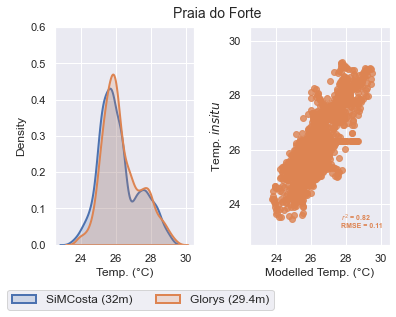

In [10]:
schema = [PF_day.Temperature,m29.thetao]
nam = ['SiMCosta (32m)', 'Glorys (29.4m)']
path_output = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/'

f1 = open(os.path.join(path_output, './Stats_Glorys_SiMCosta.txt') , 'w')
for i in range(0,len(schema)):
   print('\n',nam[i], file=f1)
   print(stats.describe(schema[i]), ('std= '+str(np.std(schema[i]))),file=f1)
f1.close()

f2 = open(os.path.join(path_output, './R2_Glorys_SiMCosta.txt') , 'w')
R = []
RMSE = []
for i in range(0,len(schema)-1):
    res = stats.pearsonr(x=schema[i+1],y=schema[0])
    err = rmse(schema[i+1][i],schema[0][i])
    print('\nPearson Corr. -', nam[i+1], nam[0],file=f2)
    print(res,file=f2)
    print(err,file=f2)
    RMSE.append(np.round(err,2))  
    R.append(np.round(res[0],2))
f2.close()

''' 
FIGURA COM SeaBorn

'''
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)

with sns.axes_style("darkgrid"):
   for i in range(0,len(schema)):
      ax1 = sns.kdeplot(data=schema[i],x = schema[i] ,fill=True, alpha=.2, linewidth=2, bw=0.2, ax=ax1)

with sns.axes_style("darkgrid"):
   for i in range(0,len(schema)-1):
      ax2 = sns.regplot(x=schema[i+1],y=schema[0], color=cmap[i+1], fit_reg = False, ax=ax2)

fig.subplots_adjust(wspace=0.4)
fig.suptitle('Praia do Forte',fontsize=14,y=.95)

ax1.set_xlabel('Temp. (°C)', fontsize=12)
ax1.set_xlim(22.5,30.5)
ax1.set_xticks([24,26,28,30])
ax1.set_ylim(0,.6)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (-.385,-.18),loc='upper left', ncol=3)


ax2.set_ylabel("Temp. $\it{in situ}$", fontsize=12)
ax2.set_xlabel('Modelled Temp. (°C)', fontsize=12)
ax2.set_ylim(22.5,30.5)
ax2.set_yticks([24,26,28,30])
ax2.set_xlim(22.5,30.5)
ax2.set_xticks([24,26,28,30])

ax2.annotate("$r^2$ = " + str(R[0]), fontsize=7,color=cmap[1],
            xy=(.65, .105), xycoords='axes fraction',fontweight="bold")
ax2.annotate("RMSE = " + str(RMSE[0]), fontsize=7,color=cmap[1],
            xy=(.65, .075), xycoords='axes fraction',fontweight="bold")

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF-Total.png', format='png', dpi=300, bbox_inches='tight')


    Serie temporal


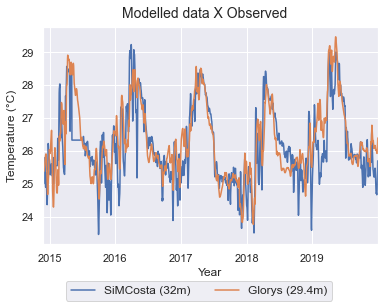

In [14]:
schema = [PF_day.Temperature,m29.thetao]
nam = ['SiMCosta (32m)', 'Glorys (29.4m)']

fig, ax1 = plt.subplots(nrows=1, ncols=1, gridspec_kw={'width_ratios':[2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)
fig.suptitle('Modelled data X Observed',fontsize=14,y=.95)

with sns.axes_style("darkgrid"):
    for i in range(0,len(schema)):
        ax1 = sns.lineplot(x=schema[i].index,y=schema[i],ax=ax1)

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.05,-.14),loc='upper left', ncol=3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF-Serie.png', format='png', dpi=300, bbox_inches='tight')

    MUR x Glorys

In [15]:
m0 = merc['thetao'].sel(depth=0,method='nearest')
m0 = m0.to_dataframe()
m0 = m0.rolling(str((P//24)+1)+'D',center=True).mean()

sst = mur['analysed_sst'].to_dataframe()
sst = sst.rolling(str((P//24)+1)+'D',center=True).mean()

    Primeira validacao
        Estatistica basica 
        plot de densidade e corelação

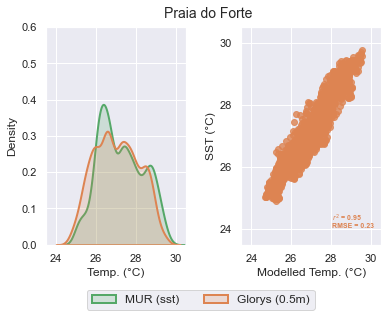

In [26]:
schema = [sst.analysed_sst,m0.thetao]
nam = ['MUR (sst)', 'Glorys (0.5m)']
path_output = 'D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/'

f1 = open(os.path.join(path_output, './Stats_Glorys_MUR.txt') , 'w')
for i in range(0,len(schema)):
   print('\n',nam[i], file=f1)
   print(stats.describe(schema[i]), ('std= '+str(np.std(schema[i]))),file=f1)
f1.close()

f2 = open(os.path.join(path_output, './R2_Glorys_MUR.txt') , 'w')
R = []
RMSE = []
for i in range(0,len(schema)-1):
      res = stats.pearsonr(x=schema[i+1],y=schema[0])
      err = rmse(schema[i+1][i],schema[0][i])
      print('\nPearson Corr. -', nam[i+1], nam[0],file=f2)
      print(res,file=f2)
      print(err,file=f2)

      R.append(np.round(res[0],2))
      RMSE.append(np.round(err,2)) 
f2.close()

''' 
FIGURA COM SeaBorn

'''
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios':[2,2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)

with sns.axes_style("darkgrid"):
   for i,c in zip(range(0,len(schema)),[2,1]):
      ax1 = sns.kdeplot(data=schema[i],x = schema[i] ,fill=True, color=cmap[c], alpha=.2, linewidth=2, bw=0.2, ax=ax1)

with sns.axes_style("darkgrid"):
   for i in range(0,len(schema)-1):
      ax2 = sns.regplot(x=schema[i+1],y=schema[0], color=cmap[i+1], fit_reg = False, ax=ax2)

fig.subplots_adjust(wspace=0.4)
fig.suptitle('Praia do Forte',fontsize=14,y=.95)

ax1.set_xlabel('Temp. (°C)', fontsize=12)
ax1.set_xlim(23.5,30.5)
ax1.set_xticks([24,26,28,30])
ax1.set_ylim(0,.6)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.25,-.18),loc='upper left', ncol=3)


ax2.set_ylabel("SST (°C)", fontsize=12)
ax2.set_xlabel('Modelled Temp. (°C)', fontsize=12)
ax2.set_ylim(23.5,30.5)
ax2.set_yticks([24,26,28,30])
ax2.set_xlim(23.5,30.5)
ax2.set_xticks([24,26,28,30])

ax2.annotate("$r^2$ = " + str(R[0]), fontsize=7,color=cmap[1],
            xy=(.65, .105), xycoords='axes fraction',fontweight="bold")
ax2.annotate("RMSE = " + str(RMSE[0]), fontsize=7,color=cmap[1],
            xy=(.65, .075), xycoords='axes fraction',fontweight="bold")

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF_superficie-Total.png', format='png', dpi=300, bbox_inches='tight')


    Serie temporal


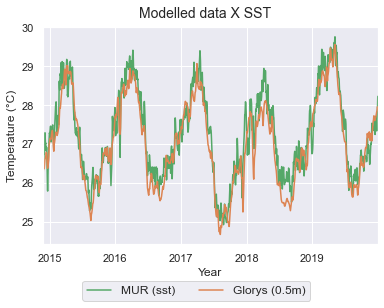

In [27]:
schema = [sst.analysed_sst,m0.thetao]
nam = ['MUR (sst)', 'Glorys (0.5m)']

fig, ax1 = plt.subplots(nrows=1, ncols=1, gridspec_kw={'width_ratios':[2], 'height_ratios':[1]})
cmap = sns.color_palette(as_cmap=True)
fig.suptitle('Modelled data X SST',fontsize=14,y=.95)

with sns.axes_style("darkgrid"):
    for i,c in zip(range(0,len(schema)),[2,1]):
        ax1 = sns.lineplot(x=schema[i].index,y=schema[i], color=cmap[c], ax=ax1)

ax1.autoscale(enable=True, axis='x', tight=True)
ax1.legend(nam,fontsize=12, bbox_to_anchor = (0.1,-.14),loc='upper left', ncol=3)
ax1.set_xlabel('Year')
ax1.set_ylabel('Temperature (°C)')

plt.savefig('D:/00_Masters/02_Resultados_Parciais/Validacao_Ocean/Validacao_PF_superficie-Serie.png', format='png', dpi=300, bbox_inches='tight')